<a href="https://colab.research.google.com/github/olakoja/Models_for_non-places/blob/main/%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_%D0%B4%D0%BB%D1%8F_%D1%8D%D0%BA%D1%81%D1%82%D1%80%D0%B0%D0%BF%D0%BE%D0%BB%D1%8F%D1%86%D0%B8%D0%B8_%D1%80%D0%B5%D0%B7%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D1%82%D0%B0_%D0%BD%D0%B0_%D0%B4%D1%80%D1%83%D0%B3%D0%B8%D0%B5_%D0%BD%D0%B0%D0%B1%D0%BE%D1%80%D1%8B_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка бибилиотек и определение ключевых моментов

In [2]:
!pip install fiona -qq

import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PowerTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import geopandas as gpd
import pandas as pd
from typing import Union, Optional
import fiona
from shapely.geometry import mapping
# ======================== КОНФИГУРАЦИЯ ========================

gdf = gpd.read_file('/content/updated_polygons_with_subway_distance.gpkg')                     # Здесь находятся входные данные для обучения
TARGET_COLUMN = "non-place1"                                          # Целевая переменная
DROP_COLUMNS = ['osm_changeset', 'osm_id', 'osm_uid', 'osm_user',
                'osm_id', 'name', 'layer', 'other_tags', 'path',
                'type', 'building:levels', 'osm_version']                                               # Столбцы, подлежащие "чистке"
new_gdf = gpd.read_file('/content/ELIZAROVSKAYA1.gpkg')                       # Тестовые данные для последующей оценки метода

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 38.8 MB/s eta 0:00:00


## Функция предобработки GeoDataFrame

In [3]:
# Функция для предварительной обработки данных перед обучением

def enhanced_preprocessing(gdf, target_column='non-place1'):
    """Полная предобработка с удалением временных столбцов
    gdf - Входной GeoDataFrame
    target_column - Целевая переменная. По умолчанию 'non-place1'
    """
    gdf = gdf.where(pd.notnull(gdf), np.nan)
    gdf = gdf.dropna(axis=1, how='all')

    geometry = gdf.geometry.copy()
    df = pd.DataFrame(gdf.drop(columns='geometry'))

    # 1. Удаление технических колонок
    tech_cols = DROP_COLUMNS
    df = df.drop(columns=[col for col in tech_cols if col in df.columns], errors='ignore')

    # 2. Удаление временных меток (просто удаляем, без преобразований)
    time_cols = df.select_dtypes(include=['datetime', 'timedelta', 'datetimetz']).columns
    df = df.drop(columns=time_cols, errors='ignore')

    # 3. Обработка целевой переменной
    if target_column in df.columns:
        df[target_column] = df[target_column].replace({'I': 'other', 'II': 'other', 'III': 'other', 'pustoe': 'other', 'water': 'other'})
        df = df.dropna(subset=[target_column])

    # 4. Обработка категориальных признаков
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        if col != target_column:
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df = pd.concat([df.drop(columns=[col]), dummies], axis=1)

    # 5. Специфичная обработка дорожных данных
    if 'road' in df.columns:
        road_dummies = df['road'].str.get_dummies(sep=',')
        road_dummies = road_dummies.add_prefix('road_')
        df = pd.concat([df.drop(columns=['road']), road_dummies], axis=1)

    # 6. Обработка площади (если есть)
    if 'area' in df.columns:
        df['area'] = pd.to_numeric(df['area'], errors='coerce')
        df['area'] = df['area'].fillna(df['area'].median())
        df['area'] = np.log1p(df['area'])  # Логарифмирование

    # 7. Заполнение пропусков в числовых колонках
    num_cols = df.select_dtypes(include=np.number).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    # 8. Удаление константных колонок
    df = df.loc[:, df.nunique() > 1]
    # 9. Удаление дубликатов строк
    df = df.drop_duplicates()

    return df, geometry

## Применение функции предобработки и обучение модели

In [4]:
# Загрузка и предобработка данных
processed_data, geometry = enhanced_preprocessing(gdf)

# Создаём новый GeoDataFrame, объединяя processed_data с геометрией
geo_df = gpd.GeoDataFrame(
    data=processed_data,
    geometry=geometry,
    crs=gdf.crs  # Сохраняем исходную систему координат
)

X = processed_data.drop(columns=[TARGET_COLUMN])
y = processed_data[TARGET_COLUMN]

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Быстрая модель (из исходного кода)
model = RandomForestClassifier(
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# ======================== Вывод результатов ========================
# Оценка модели
y_pred = model.predict(X_test)

# Получаем вероятности для всего геодатафрейма
probabilities_full = model.predict_proba(X)  # Убрали named_steps, так как model не Pipeline

# Записываем предсказанные вероятности
geo_df['Predicted_Probability'] = probabilities_full[:, 1]

# Оценка модели
y_pred = model.predict(X_test)

print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred))

average_accuracy = accuracy_score(y_test, y_pred)  # Заменили y_res на y_test
print(f"Средняя точность: {average_accuracy:.2f}")



Отчет о классификации:
              precision    recall  f1-score   support

   non-place       0.86      0.30      0.44        60
       other       0.86      0.99      0.92       261

    accuracy                           0.86       321
   macro avg       0.86      0.64      0.68       321
weighted avg       0.86      0.86      0.83       321

Средняя точность: 0.86


## Анализ признаков


Топ-20 важных признаков (включая отрицательные):
                                Feature  Importance  Absolute Importance
19                                 area    0.134279             0.134279
0                       boundary_length    0.127811             0.127811
15                    crossing_distance    0.095910             0.095910
13                        urna_distance    0.092883             0.092883
23                      subway_distance    0.090742             0.090742
14                     parking_distance    0.090492             0.090492
16                         bus_distance    0.083384             0.083384
17                       bench_distance    0.079378             0.079378
6                neighbor_ratio_service    0.018286             0.018286
5      neighbor_boundary_length_service    0.016606             0.016606
2                neighbor_ratio_I_place    0.011195             0.011195
244                        road_service    0.010353             0.010353
2

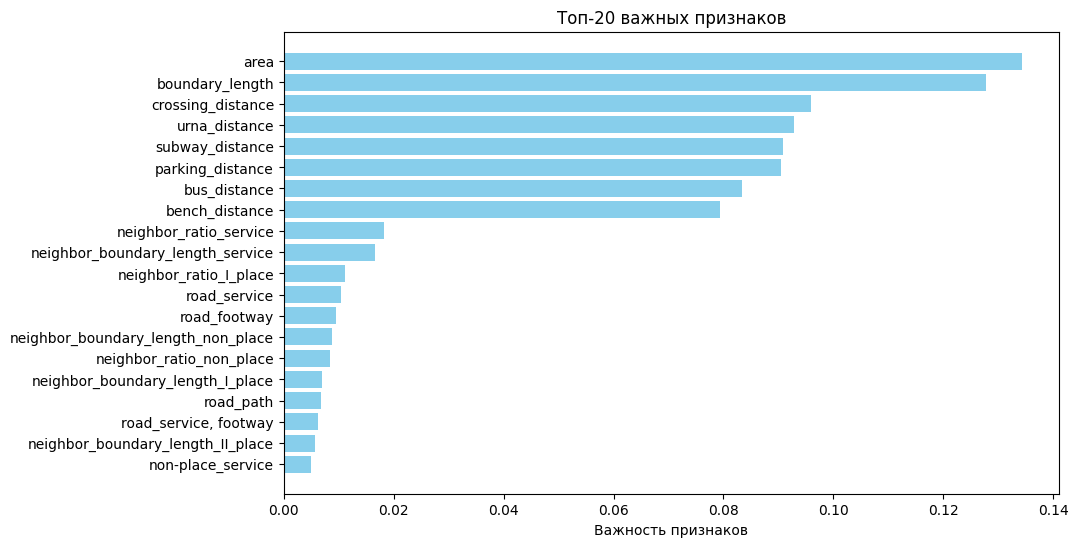

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Анализ важности признаков
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})

# Сортируем по абсолютной величине важности
importances['Absolute Importance'] = importances['Importance'].abs()
importances = importances.sort_values('Absolute Importance', ascending=False)

# Выводим топ-10 важных признаков
print("\nТоп-20 важных признаков (включая отрицательные):")
print(importances.head(20))

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'].head(20), importances['Importance'].head(20), color='skyblue')
plt.xlabel('Важность признаков')
plt.title('Топ-20 важных признаков')
plt.gca().invert_yaxis()  # Инвертируем ось Y, чтобы самый важный признак был сверху
plt.show()

Сохранение признаков в файл

In [6]:
importances.to_csv("Коэффициенты по обучающим данным.csv")

# Применение модели к проверочным данным

In [7]:
# Создаём функцию для приведения новых данных к формату, необходимому для применения модели
def process_geodataframes(
    original_df: pd.DataFrame,
    original_geometry: Union[str, gpd.GeoSeries],
    processed_gdf: gpd.GeoDataFrame,
    model_features: Optional[list] = None,
    keep_geometry: bool = True
) -> gpd.GeoDataFrame:
    """
    Приводит структуру геодатафрейма к структуре, ожидаемой моделью.

    Параметры:
    ----------
    original_df : pd.DataFrame
        Исходный датафрейм, использованный для обучения модели
    original_geometry : str или gpd.GeoSeries
        Название столбца с геометрией или сама геометрия
    processed_gdf : gpd.GeoDataFrame
        Новый геодатафрейм для обработки
    model_features : list, optional
        Список признаков, которые использует модель (если None, берутся из original_df)
    keep_geometry : bool, optional
        Сохранять ли исходную геометрию processed_gdf

    Возвращает:
    -----------
    gpd.GeoDataFrame
        Геодатафрейм с признаками в том же порядке, что и при обучении модели
    """
    # Определяем признаки модели
    if model_features is None:
        model_features = original_df.columns.tolist()
        if isinstance(original_geometry, str) and original_geometry in model_features:
            model_features.remove(original_geometry)

    # Сохраняем геометрию
    geometry = processed_gdf.geometry if keep_geometry else original_gdf.geometry

    # Создаём DataFrame с нужными признаками
    result_df = pd.DataFrame(index=processed_gdf.index)

    # Добавляем признаки в правильном порядке
    for feature in model_features:
        if feature in processed_gdf.columns:
            result_df[feature] = processed_gdf[feature]
        else:
            # Заполняем отсутствующие признаки нулями/пустыми значениями
            if feature in original_df.columns:
                dtype = original_df[feature].dtype
                if pd.api.types.is_numeric_dtype(dtype):
                    result_df[feature] = 0
                elif pd.api.types.is_datetime64_any_dtype(dtype):
                    result_df[feature] = pd.NaT
                elif pd.api.types.is_bool_dtype(dtype):
                    result_df[feature] = False
                elif pd.api.types.is_categorical_dtype(dtype):
                    result_df[feature] = pd.Categorical([], categories=original_df[feature].cat.categories)
                else:
                    result_df[feature] = ''
            else:
                result_df[feature] = 0  # Для неизвестных признаков

    # Создаём итоговый GeoDataFrame
    result_gdf = gpd.GeoDataFrame(
        result_df,
        geometry=geometry,
        crs=processed_gdf.crs
    )

    return result_gdf

In [ ]:
# Применяем функцию и получаем предсказания

processed_data = process_geodataframes(
    original_df=geo_df,
    original_geometry=geometry,
    processed_gdf=new_gdf
)
geometry = processed_data['geometry'].copy()
# Теперь можно безопасно делать предсказания
predictions = model.predict(processed_data.drop(columns=['geometry', 'Predicted_Probability', 'non-place1']))

In [9]:
#Формируем GeoDataFrame

predictions_df = gpd.GeoDataFrame(
    data=predictions,
    geometry=geometry,
    crs=gdf.crs  # Сохраняем исходную систему координат
)

# !!!
Перед запуском ячейки с сохранением данных в файл обязательно удалить файл с названием predictions_with_geometry.gpkg из целевой папки

In [10]:
# Убедитесь, что  схема для GeoDataFrame правильная
schema = {
    'geometry': 'MultiPolygon',  # Замените на нужный тип геометрии
    'properties': {'0': 'str'}  # Используем имя столбца '0' как строку
}

# Открываем файл для записи
with fiona.open('predictions_with_geometry.gpkg', mode='w', driver='GPKG', crs=predictions_df.crs, schema=schema) as dst:
    for _, row in predictions_df.iterrows():
        dst.write({
            'geometry': mapping(row['geometry']),
            'properties': {'0': row[0]}  # Используем имя столбца 0
        })